<a href="https://colab.research.google.com/github/PoliNemkova/conflict_prediction_2025/blob/main/Sudan/%5Bsliding_window_of_4_weeks%5D_%5B2%5D_Conflict_Prediction_LLM_for_Sudan_feature_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### Acled data

In [ ]:
# loading ACLED
acled = pd.read_csv('/content/gdrive/MyDrive/CONFLICT PREDICTION/Fall 2024/acled_bin_all_countries_since_2015.csv')

acled.head(10)

,Country_Name_Short,sum(ACLED_Fatalities),STARTDATE,ENDDATE,abs_change,pct_increase,bin_esc_30
0,Afghanistan,271,2020-01-13,2020-01-20,-1478.0,-8.450543e+01,0
1,Afghanistan,796,2020-09-14,2020-09-21,525.0,1.937269e+02,1
2,Afghanistan,17,2022-12-12,2022-12-19,-779.0,-9.786432e+01,0
3,Afghanistan,17,2023-04-17,2023-04-24,0.0,0.000000e+00,0
4,Afghanistan,14,2023-05-15,2023-05-22,-3.0,-1.764706e+01,0
5,Albania,0,2021-06-14,2021-06-21,0.0,0.000000e+00,0
6,Albania,0,2019-01-07,2019-01-14,0.0,0.000000e+00,0
7,Albania,0,2020-08-31,2020-09-07,0.0,0.000000e+00,0
8,Algeria,0,2018-09-24,2018-10-01,0.0,0.000000e+00,0
9,Algeria,1,2020-05-18,2020-05-25,1.0,1.000000e+12,1


In [ ]:
acled_sudan = acled[(acled['Country_Name_Short'] == 'Sudan') &
                    #(acled['STARTDATE'] <= '2023-12-31' &)
                    (acled['STARTDATE'] >= '2020-01-01')]

len(acled_sudan)

245

In [ ]:
acled_sudan['STARTDATE'].max()

'2024-09-16'

In [ ]:
acled_sudan['sum(ACLED_Fatalities)'].describe()

,sum(ACLED_Fatalities)
count,245.000000
mean,116.702041
std,199.242328
min,0.000000
25%,11.000000
50%,31.000000
75%,172.000000
max,1669.000000


In [ ]:
# applying transformation for normalizing the fatalities
import numpy as np
acled_sudan['log_fatalities'] = np.log(acled_sudan['sum(ACLED_Fatalities)'] + 1)

<ipython-input-79-029704a49aff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acled_sudan['log_fatalities'] = np.log(acled_sudan['sum(ACLED_Fatalities)'] + 1)


In [ ]:
acled_sudan.sort_values(by='STARTDATE', inplace=True)

<ipython-input-80-31b055096895>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acled_sudan.sort_values(by='STARTDATE', inplace=True)


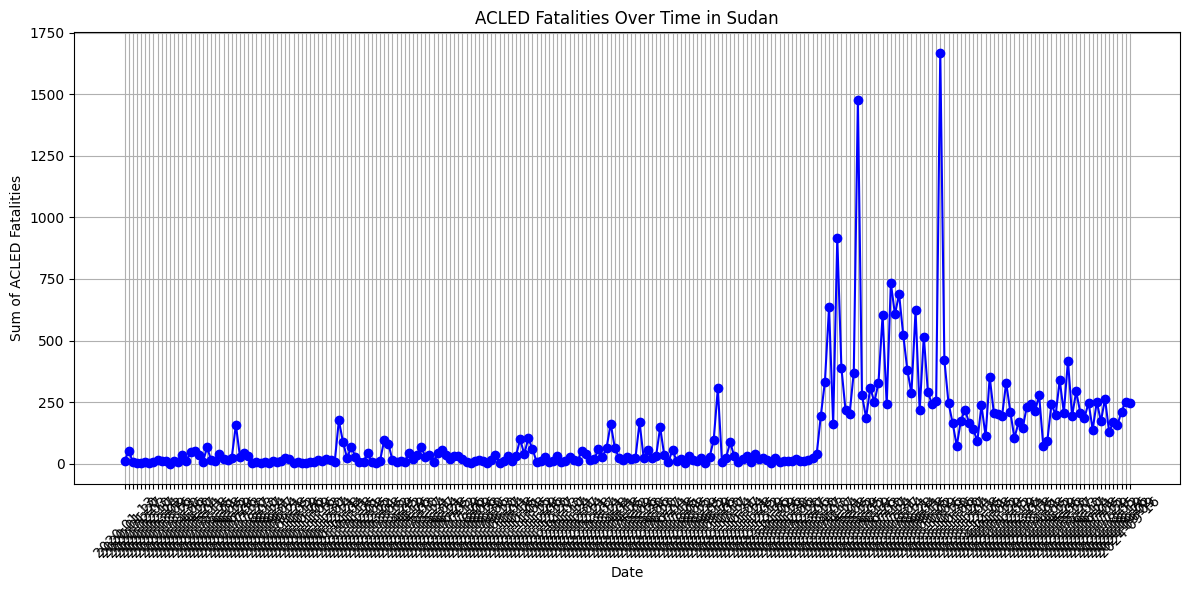

In [ ]:
# Importing the required libraries
import matplotlib.pyplot as plt
import pandas as pd

# Sample data with your specified columns
data = {
    'STARTDATE': acled_sudan['STARTDATE'].to_list() ,
    'sum(ACLED_Fatalities)': acled_sudan['sum(ACLED_Fatalities)'].to_list()
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(df['STARTDATE'], df['sum(ACLED_Fatalities)'], marker='o', linestyle='-', color='b')
plt.title('ACLED Fatalities Over Time in Sudan')
plt.xlabel('Date')
plt.ylabel('Sum of ACLED Fatalities')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


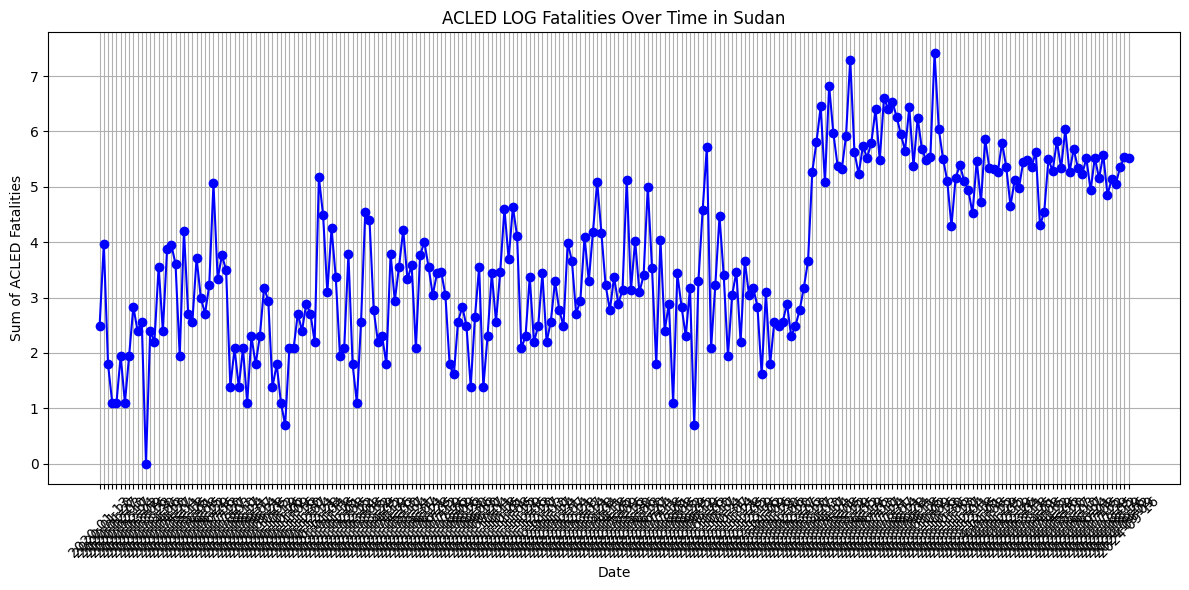

In [ ]:
# Importing the required libraries
import matplotlib.pyplot as plt
import pandas as pd

# Sample data with your specified columns
data = {
    'STARTDATE': acled_sudan['STARTDATE'].to_list() ,
    'log_fatalities': acled_sudan['log_fatalities'].to_list()
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(df['STARTDATE'], df['log_fatalities'], marker='o', linestyle='-', color='b')
plt.title('ACLED LOG Fatalities Over Time in Sudan')
plt.xlabel('Date')
plt.ylabel('Sum of ACLED Fatalities')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


### Sliding windows

In [ ]:
import pandas as pd

# Assuming acled_sudan is the weekly DataFrame
# Make sure 'STARTDATE' and 'ENDDATE' are in datetime format
acled_sudan['STARTDATE'] = pd.to_datetime(acled_sudan['STARTDATE'])
acled_sudan['ENDDATE'] = pd.to_datetime(acled_sudan['ENDDATE'])

# Initialize lists to store the new sliding window data
window_starts, window_ends, window_fatalities, week_5_fatalities = [], [], [], []

# Sliding window size (4 weeks)
window_size = 4

# Create sliding windows of 4 weeks
for i in range(len(acled_sudan) - window_size):
    # Window 1 to 4 (4-week period)
    window_start = acled_sudan['STARTDATE'].iloc[i]
    window_end = acled_sudan['ENDDATE'].iloc[i + window_size - 1]
    window_fatality = acled_sudan['sum(ACLED_Fatalities)'].iloc[i:i + window_size].sum()

    # Fatalities in the 5th week (following the 4-week period)
    if i + window_size < len(acled_sudan):
        # If 5th week data exists, use it
        week_5_fatality = acled_sudan['sum(ACLED_Fatalities)'].iloc[i + window_size]
    else:
        # If 5th week data doesn't exist, calculate mean of the last two available weeks
        if i + window_size - 1 >= 1:  # Make sure there are at least two previous weeks
            week_5_fatality = (
                acled_sudan['sum(ACLED_Fatalities)'].iloc[i + window_size - 2] +
                acled_sudan['sum(ACLED_Fatalities)'].iloc[i + window_size - 1]
            ) / 2
        else:
            # If there are not enough previous weeks, fallback to 0 (or another value you choose)
            week_5_fatality = 0

    # Store the data
    window_starts.append(window_start)
    window_ends.append(window_end)
    window_fatalities.append(window_fatality)
    week_5_fatalities.append(week_5_fatality)

# Create the new DataFrame for the 4-week sliding window with the 5th week's fatalities
acled_sudan_4week_window = pd.DataFrame({
    'STARTDATE': window_starts,
    'ENDDATE': window_ends,
    'sum(ACLED_Fatalities)': window_fatalities,
    '5th_Week_Fatalities': week_5_fatalities
})
acled_sudan_4week_window

<ipython-input-83-151d6602e8c6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acled_sudan['STARTDATE'] = pd.to_datetime(acled_sudan['STARTDATE'])
<ipython-input-83-151d6602e8c6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acled_sudan['ENDDATE'] = pd.to_datetime(acled_sudan['ENDDATE'])


,STARTDATE,ENDDATE,sum(ACLED_Fatalities),5th_Week_Fatalities
0,2020-01-13,2020-02-10,70,2
1,2020-01-20,2020-02-17,61,6
2,2020-01-27,2020-02-24,15,2
3,2020-02-03,2020-03-02,12,6
4,2020-02-10,2020-03-09,16,16
...,...,...,...,...
236,2024-07-22,2024-08-19,814,169
237,2024-07-29,2024-08-26,732,156
238,2024-08-05,2024-09-02,716,211
239,2024-08-12,2024-09-09,664,252


In [ ]:
len(acled_sudan_4week_window)

241

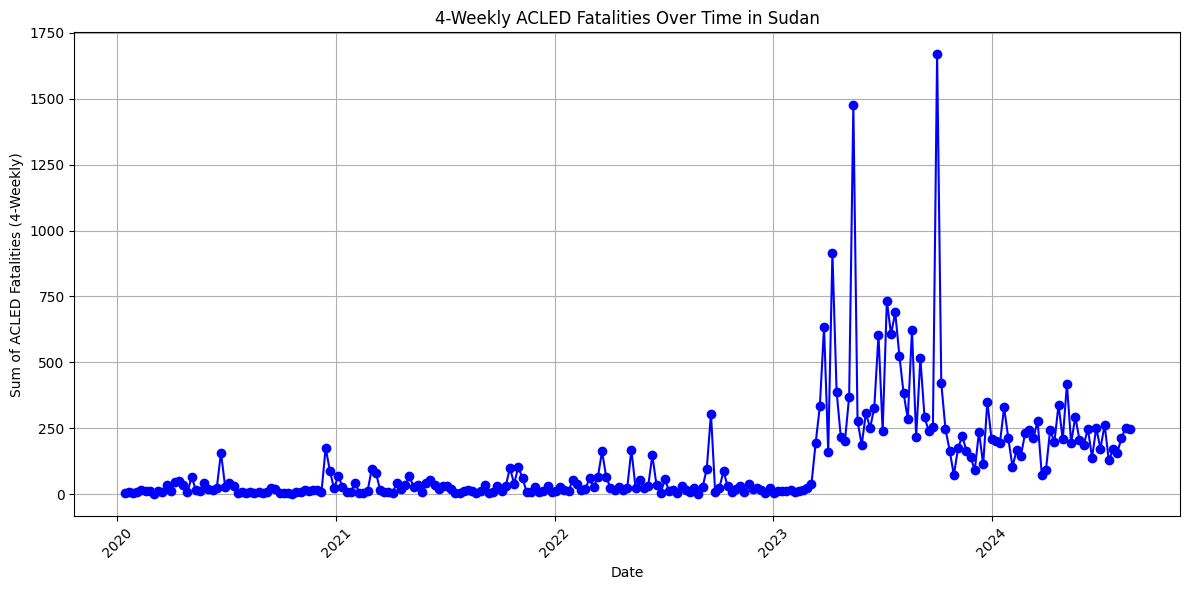

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = acled_sudan_4week_window
# Plotting the 4-weekly aggregated data
plt.figure(figsize=(12, 6))
plt.plot(df['STARTDATE'], df['5th_Week_Fatalities'], marker='o', linestyle='-', color='b')
plt.title('4-Weekly ACLED Fatalities Over Time in Sudan')
plt.xlabel('Date')
plt.ylabel('Sum of ACLED Fatalities (4-Weekly)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


looking closer at what do we want to call 'positives'

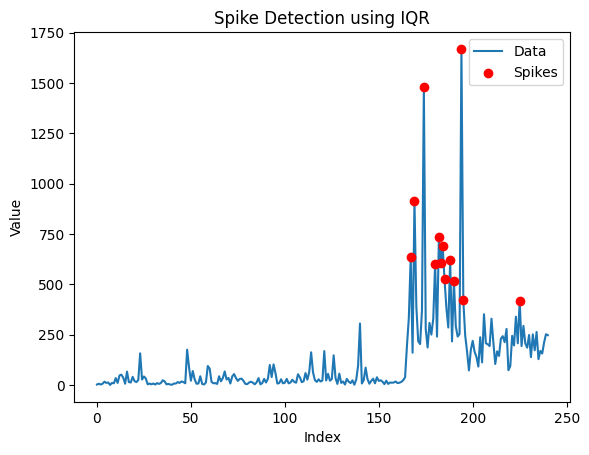

Spike at index 167, value: 635
Spike at index 169, value: 916
Spike at index 174, value: 1478
Spike at index 180, value: 603
Spike at index 182, value: 734
Spike at index 183, value: 606
Spike at index 184, value: 689
Spike at index 185, value: 524
Spike at index 188, value: 622
Spike at index 190, value: 516
Spike at index 194, value: 1669
Spike at index 195, value: 420
Spike at index 225, value: 418


In [ ]:
# applying to all data

# Calculate the IQR (Interquartile Range)
data = acled_sudan_4week_window['5th_Week_Fatalities']
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1
index = np.arange(len(data))

# Define the threshold for detecting outliers (e.g., 1.5 * IQR)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers (spikes) that are outside of the IQR bounds
spike_indices_iqr = np.where((data < lower_bound) | (data > upper_bound))[0]

# Plot the data
plt.plot(index, data, label='Data')
plt.scatter(spike_indices_iqr, data[spike_indices_iqr], color='red', label='Spikes', zorder=5)
plt.title('Spike Detection using IQR')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

# Print spike indices and their values
for idx in spike_indices_iqr:
    print(f"Spike at index {idx}, value: {data[idx]}")


splitting dataset on portions due to change in rolling average

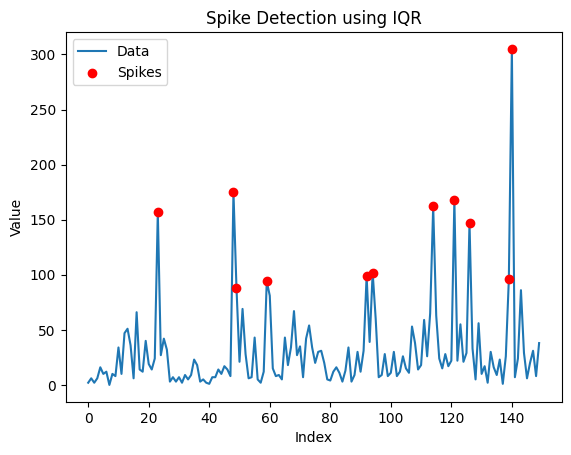

Spike at index 23, value: 157
Spike at index 48, value: 175
Spike at index 49, value: 88
Spike at index 59, value: 94
Spike at index 92, value: 99
Spike at index 94, value: 102
Spike at index 114, value: 162
Spike at index 121, value: 168
Spike at index 126, value: 147
Spike at index 139, value: 96
Spike at index 140, value: 305


In [ ]:
# Calculate the IQR (Interquartile Range)
data = acled_sudan_4week_window['5th_Week_Fatalities'][:150]
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1
index = np.arange(len(data))

# Define the threshold for detecting outliers (e.g., 1.5 * IQR)
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

# Identify outliers (spikes) that are outside of the IQR bounds
spike_indices_iqr = np.where((data < lower_bound) | (data > upper_bound))[0]

# Add a binary 'importance' column to mark spikes
importance = np.zeros(len(data), dtype=int)
importance[spike_indices_iqr] = 1  # Mark spikes with 1

# Add the importance column to the DataFrame (for the first 150 rows in this case)
acled_sudan_4week_window['importance'] = np.zeros(len(acled_sudan_4week_window), dtype=int)
acled_sudan_4week_window.loc[:149, 'importance'] = importance

# Plot the data
plt.plot(index, data, label='Data')
plt.scatter(spike_indices_iqr, data[spike_indices_iqr], color='red', label='Spikes', zorder=5)
plt.title('Spike Detection using IQR')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

# Print spike indices and their values
for idx in spike_indices_iqr:
    print(f"Spike at index {idx}, value: {data[idx]}")


In [ ]:
acled_sudan_4week_window['importance'].value_counts()

,count
importance,
0,230
1,11


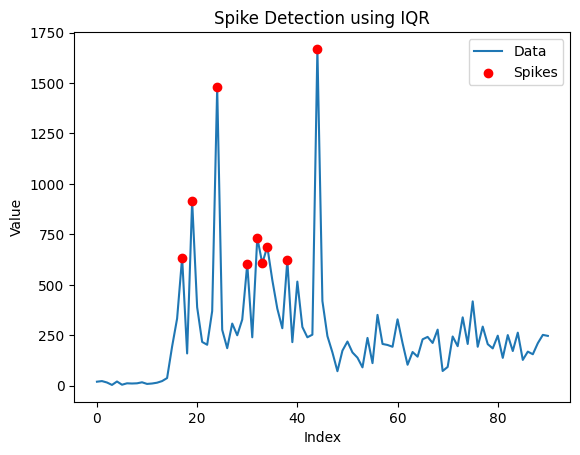

Spike at index 17, value: 635
Spike at index 19, value: 916
Spike at index 24, value: 1478
Spike at index 30, value: 603
Spike at index 32, value: 734
Spike at index 33, value: 606
Spike at index 34, value: 689
Spike at index 38, value: 622
Spike at index 44, value: 1669


In [ ]:
# Calculate the IQR (Interquartile Range)

data = acled_sudan_4week_window['5th_Week_Fatalities'][150:]
data.reset_index(drop=True, inplace=True)
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1
index = np.arange(len(data))

# Define the threshold for detecting outliers (e.g., 1.5 * IQR)
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

# Identify outliers (spikes) that are outside of the IQR bounds
spike_indices_iqr = np.where((data < lower_bound) | (data > upper_bound))[0]

# Add a binary 'importance' column to mark spikes
importance = np.zeros(len(data), dtype=int)
importance[spike_indices_iqr] = 1  # Mark spikes with 1

# Add the importance column to the DataFrame (for the first 150 rows in this case)
#acled_sudan_4week_window['importance'] = np.zeros(len(acled_sudan_4week_window), dtype=int)
acled_sudan_4week_window.loc[150:, 'importance'] = importance

# Plot the data
plt.plot(index, data, label='Data')
plt.scatter(spike_indices_iqr, data[spike_indices_iqr], color='red', label='Spikes', zorder=5)
plt.title('Spike Detection using IQR')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

# Print spike indices and their values
for idx in spike_indices_iqr:
    print(f"Spike at index {idx}, value: {data[idx]}")


In [ ]:
acled_sudan_4week_window['importance'].value_counts()

,count
importance,
0,221
1,20


In [ ]:
# adding timespots for simplicity

acled_sudan_4week_window['timeslot'] = range(0, len(acled_sudan_4week_window))
acled_sudan_4week_window.head(10)

,STARTDATE,ENDDATE,sum(ACLED_Fatalities),5th_Week_Fatalities,importance,timeslot
0,2020-01-13,2020-02-10,70,2,0,0
1,2020-01-20,2020-02-17,61,6,0,1
2,2020-01-27,2020-02-24,15,2,0,2
3,2020-02-03,2020-03-02,12,6,0,3
4,2020-02-10,2020-03-09,16,16,0,4
5,2020-02-17,2020-03-16,30,10,0,5
6,2020-02-24,2020-03-23,34,12,0,6
7,2020-03-02,2020-03-30,44,0,0,7
8,2020-03-09,2020-04-06,38,10,0,8
9,2020-03-16,2020-04-13,32,8,0,9


### Texts and events data

In [ ]:
sudan = pd.read_csv('/content/gdrive/My Drive/CONFLICT PREDICTION/Fall 2024/sudan_since2020_events+text+RuBERTenc.csv')

In [ ]:
#sudan = pd.read_csv('/content/grive/MyDrive/CONFLICT PREDICTION/Fall 2024/Sudan Data/sudan_2023_events+text+enc.csv')

In [ ]:
len(sudan)

3453

In [ ]:
sudan.columns

Index(['Unnamed: 0', 'index', 'globaleventid', 'sqldate', 'monthyear', 'year',
       'fractiondate', 'actor1code', 'actor1name', 'actor1countrycode',
       'actor1knowngroupcode', 'actor1ethniccode', 'actor1religion1code',
       'actor1religion2code', 'actor1type1code', 'actor1type2code',
       'actor1type3code', 'actor2code', 'actor2name', 'actor2countrycode',
       'actor2knowngroupcode', 'actor2ethniccode', 'actor2religion1code',
       'actor2religion2code', 'actor2type1code', 'actor2type2code',
       'actor2type3code', 'isrootevent', 'eventcode', 'cameocodedescription',
       'eventbasecode', 'eventrootcode', 'quadclass', 'goldsteinscale',
       'nummentions', 'numsources', 'numarticles', 'avgtone', 'actor1geotype',
       'actor1geofullname', 'actor1geocountrycode', 'actor1geoadm1code',
       'actor1geoadm2code', 'actor1geolat', 'actor1geolong',
       'actor1geofeatureid', 'actor2geotype', 'actor2geofullname',
       'actor2geocountrycode', 'actor2geoadm1code', 'actor2g

In [ ]:
sudan_2023 = sudan

In [ ]:
sudan_2023.head()

,Unnamed: 0,index,globaleventid,sqldate,monthyear,year,fractiondate,actor1code,actor1name,actor1countrycode,...,actiongeoadm1code,actiongeoadm2code,actiongeolat,actiongeolong,actiongeofeatureid,dateadded,sourceurl,geometry,text,embeddings
0,13,6,897701154,2020-01-08,202001,2020,2020.0219,SDN,SUDAN,SDN,...,USDC,DC001,38.8951,-77.0364,531871,20200108234500,http://www.jordantimes.com/news/region/us-sanc...,POINT (-77.0364 38.8951),WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...
1,14,8,897701458,2020-01-08,202001,2020,2020.0219,USA,UNITED STATES,USA,...,USDC,DC001,38.8951,-77.0364,531871,20200108234500,http://www.jordantimes.com/news/region/us-sanc...,POINT (-77.0364 38.8951),WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...
2,15,7,897701455,2020-01-08,202001,2020,2020.0219,USA,WASHINGTON,USA,...,SU,NaN,16.0000,30.0000,SU,20200108234500,http://www.jordantimes.com/news/region/us-sanc...,POINT (30 16),WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...
3,18,28,898816289,2020-01-13,202001,2020,2020.0356,SDNGOV,SUDAN,SDN,...,SU55,37080,13.3267,24.8534,11081854,20200113234500,https://cpj.org/2020/01/sudan-suspends-four-ne...,POINT (24.8534 13.3267),Share this: Twitter\n\nFacebook\n\nWhatsApp\n\...,[-8.33870471e-01 -5.70861101e-01 3.74339998e-...
4,19,29,898816290,2020-01-13,202001,2020,2020.0356,SDNGOV,SUDANESE,SDN,...,SU55,37080,13.3267,24.8534,11081854,20200113234500,https://cpj.org/2020/01/sudan-suspends-four-ne...,POINT (24.8534 13.3267),Share this: Twitter\n\nFacebook\n\nWhatsApp\n\...,[-8.33870471e-01 -5.70861101e-01 3.74339998e-...


In [ ]:
# Matching timeslots to data in GDELT Sudan


acled_sudan_4week_window['STARTDATE'] = pd.to_datetime(acled_sudan_4week_window['STARTDATE'], errors='coerce')
acled_sudan_4week_window['ENDDATE'] = pd.to_datetime(acled_sudan_4week_window['ENDDATE'], errors='coerce')

# Create an IntervalIndex from the first table
timeslot_intervals = pd.IntervalIndex.from_arrays(
    acled_sudan_4week_window['STARTDATE'],
    acled_sudan_4week_window['ENDDATE'],
    closed='both'
)

# Assign the timeslot based on which interval each date falls into
sudan_2023['timeslot'] = sudan_2023['sqldate'].apply(
    lambda x: acled_sudan_4week_window.loc[timeslot_intervals.contains(x), 'timeslot'].iloc[0] if any(timeslot_intervals.contains(x)) else None
)

# fix the last timeslot that didn't have shifting reference

sudan_2023['timeslot'].fillna(26, inplace=True)
sudan_2023['timeslot'] = sudan_2023['timeslot'].astype(int)

sudan_2023.head(5)


<ipython-input-29-9b44d75aec69>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sudan_2023['timeslot'].fillna(26, inplace=True)


,Unnamed: 0,index,globaleventid,sqldate,monthyear,year,fractiondate,actor1code,actor1name,actor1countrycode,...,actiongeoadm2code,actiongeolat,actiongeolong,actiongeofeatureid,dateadded,sourceurl,geometry,text,embeddings,timeslot
0,13,6,897701154,2020-01-08,202001,2020,2020.0219,SDN,SUDAN,SDN,...,DC001,38.8951,-77.0364,531871,20200108234500,http://www.jordantimes.com/news/region/us-sanc...,POINT (-77.0364 38.8951),WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...,26
1,14,8,897701458,2020-01-08,202001,2020,2020.0219,USA,UNITED STATES,USA,...,DC001,38.8951,-77.0364,531871,20200108234500,http://www.jordantimes.com/news/region/us-sanc...,POINT (-77.0364 38.8951),WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...,26
2,15,7,897701455,2020-01-08,202001,2020,2020.0219,USA,WASHINGTON,USA,...,NaN,16.0000,30.0000,SU,20200108234500,http://www.jordantimes.com/news/region/us-sanc...,POINT (30 16),WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...,26
3,18,28,898816289,2020-01-13,202001,2020,2020.0356,SDNGOV,SUDAN,SDN,...,37080,13.3267,24.8534,11081854,20200113234500,https://cpj.org/2020/01/sudan-suspends-four-ne...,POINT (24.8534 13.3267),Share this: Twitter\n\nFacebook\n\nWhatsApp\n\...,[-8.33870471e-01 -5.70861101e-01 3.74339998e-...,0
4,19,29,898816290,2020-01-13,202001,2020,2020.0356,SDNGOV,SUDANESE,SDN,...,37080,13.3267,24.8534,11081854,20200113234500,https://cpj.org/2020/01/sudan-suspends-four-ne...,POINT (24.8534 13.3267),Share this: Twitter\n\nFacebook\n\nWhatsApp\n\...,[-8.33870471e-01 -5.70861101e-01 3.74339998e-...,0


In [ ]:
sudan_2023['timeslot'].nunique()

198

In [ ]:
sudan_2023.iloc[450]

,450
Unnamed: 0,718
index,710
globaleventid,944922682
sqldate,2020-09-05
monthyear,202009
...,...
sourceurl,https://cruxnow.com/church-in-africa/2020/09/s...
geometry,POINT (30.35 13.0833)
text,"In this Oct. 14, 2019 file photo, provided by ..."
embeddings,[-7.23373890e-01 -4.94707406e-01 4.02536869e-...


In [ ]:
# dropping bunch of columns from GDELT that are currently not used

sudan_light = sudan_2023[['globaleventid', 'sqldate', 'goldsteinscale',
       'nummentions', 'numsources', 'numarticles', 'avgtone',  'text',
       'embeddings', 'timeslot']]

In [ ]:
acled_sudan_4week_window.columns

Index(['STARTDATE', 'ENDDATE', 'sum(ACLED_Fatalities)', '5th_Week_Fatalities',
       'importance', 'timeslot'],
      dtype='object')

In [ ]:
# adding importance (positivity sign) to the GDELT set

sudan_light = pd.merge(sudan_light, acled_sudan_4week_window[['timeslot', 'importance']], on='timeslot', how='left')
sudan_light

,globaleventid,sqldate,goldsteinscale,nummentions,numsources,numarticles,avgtone,text,embeddings,timeslot,importance
0,897701154,2020-01-08,4.0,3,1,3,-5.902778,WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...,26,0
1,897701458,2020-01-08,3.0,4,1,4,-5.902778,WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...,26,0
2,897701455,2020-01-08,-2.0,7,1,7,-5.902778,WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...,26,0
3,898816289,2020-01-13,7.0,2,1,2,-2.457467,Share this: Twitter\n\nFacebook\n\nWhatsApp\n\...,[-8.33870471e-01 -5.70861101e-01 3.74339998e-...,0,0
4,898816290,2020-01-13,-9.2,6,1,6,-2.457467,Share this: Twitter\n\nFacebook\n\nWhatsApp\n\...,[-8.33870471e-01 -5.70861101e-01 3.74339998e-...,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3448,1201371584,2024-09-30,4.0,10,1,10,2.469136,The University of Liverpool's Garstang Museum ...,[-6.91688359e-01 -4.92898405e-01 5.33296108e-...,26,0
3449,1202058978,2024-10-03,3.0,1,1,1,-6.661251,At The 79th session of the UN General Assembly...,[-8.68785858e-01 -4.65599090e-01 3.23871851e-...,26,0
3450,1202272879,2024-10-04,3.5,8,1,8,-3.776978,JUBA (Oct 5): Since South Sudan gained indepen...,[-7.55898714e-01 -4.57526714e-01 4.63749051e-...,26,0
3451,1202273147,2024-10-04,-2.0,8,1,8,-3.776978,JUBA (Oct 5): Since South Sudan gained indepen...,[-7.55898714e-01 -4.57526714e-01 4.63749051e-...,26,0


In [ ]:
# working with positive examples

positive_articles = sudan_light[sudan_light['importance'] == 1]
negative_articles = sudan_light[sudan_light['importance'] == 0]

len(positive_articles), len(negative_articles)

(415, 3038)

In [ ]:
positive_articles['text'].nunique()

93

In [ ]:
negative_articles['text'].nunique()

545

##### Cosine Similarity with Positive and Negative average embedding

In [ ]:
# getting mean positive embedding

arrays = []
for item in positive_articles['embeddings']:
  string_list = item.replace('[', ' ').replace(']', ' ').replace('\n', ' ').split()
  final = [float(number) for number in string_list]
  arrays.append(final)

array = np.array(arrays)
mean_positive_embedding = array.mean(axis=0)
len(mean_positive_embedding)

768

In [ ]:
# getting mean negative embedding

arrays = []
for item in negative_articles['embeddings']:
  string_list = item.replace('[', ' ').replace(']', ' ').replace('\n', ' ').split()
  final = [float(number) for number in string_list]
  arrays.append(final)

array = np.array(arrays)
mean_negative_embedding = array.mean(axis=0)
len(mean_negative_embedding)

768

In [ ]:
# calculate cosign similarity with negative and positive embeddings across the GDELT set

from sklearn.metrics.pairwise import cosine_similarity

cos_sim_pos = []
cos_sim_neg = []

for i in range(len(sudan_light)):
  string_list = sudan_light['embeddings'].iloc[i].replace('[', ' ').replace(']', ' ').replace('\n', ' ').split()
  numeric_embedding = [float(number) for number in string_list]
  similarity_positive = cosine_similarity(np.array(numeric_embedding).reshape(1, -1), np.array(mean_positive_embedding).reshape(1, -1))
  cos_sim_pos.append(similarity_positive[0][0])
  similarity_negative = cosine_similarity(np.array(numeric_embedding).reshape(1, -1), np.array(mean_negative_embedding).reshape(1, -1))
  cos_sim_neg.append(similarity_negative[0][0])

sudan_light['cosine_similarity_positive'] = cos_sim_pos
sudan_light['cosine_similarity_negative'] = cos_sim_neg

In [ ]:
sudan_light.head(5)

,globaleventid,sqldate,goldsteinscale,nummentions,numsources,numarticles,avgtone,text,embeddings,timeslot,importance,cosine_similarity_positive,cosine_similarity_negative
0,897701154,2020-01-08,4.0,3,1,3,-5.902778,WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...,26,0,0.973195,0.973674
1,897701458,2020-01-08,3.0,4,1,4,-5.902778,WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...,26,0,0.973195,0.973674
2,897701455,2020-01-08,-2.0,7,1,7,-5.902778,WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...,26,0,0.973195,0.973674
3,898816289,2020-01-13,7.0,2,1,2,-2.457467,Share this: Twitter\n\nFacebook\n\nWhatsApp\n\...,[-8.33870471e-01 -5.70861101e-01 3.74339998e-...,0,0,0.968439,0.968642
4,898816290,2020-01-13,-9.2,6,1,6,-2.457467,Share this: Twitter\n\nFacebook\n\nWhatsApp\n\...,[-8.33870471e-01 -5.70861101e-01 3.74339998e-...,0,0,0.968439,0.968642


##### Topic Modeling

In [ ]:
# adding topic modeling

!pip install pandas numpy gensim scikit-learn nltk

import pandas as pd
import numpy as np
import nltk
import gensim
from gensim import corpora
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Download NLTK data (only the first time)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Load your dataset (replace this with your actual dataset)
articles = sudan_light['text']

# Define custom stop words
stop_words = set(stopwords.words('english')).union(ENGLISH_STOP_WORDS)

# Preprocess the text
def preprocess_text(text):
    # Tokenize, remove punctuation, stop words, and convert to lowercase
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

articles['tokens'] = articles.apply(preprocess_text)


# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(articles['tokens'])

# Filter out words that occur too frequently or too rarely
dictionary.filter_extremes(no_below=2, no_above=0.5)

# Create the bag-of-words corpus
corpus = [dictionary.doc2bow(tokens) for tokens in articles['tokens']]


from gensim.models import LdaModel

# Train the LDA model
num_topics = 20  # Adjust the number of topics as needed
lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

# Display the topics found by the model
topics = lda_model.print_topics(num_words=3)
for topic in topics:
    print(topic)

# Function to get top N topics for a document
def get_top_topics(lda_model, corpus, n=3):
    top_topics = []
    for bow in corpus:
        topic_probs = lda_model.get_document_topics(bow)
        # Sort topics by their probability in descending order
        top_n = sorted(topic_probs, key=lambda x: x[1], reverse=True)[:n]
        top_topics.append([topic_id for topic_id, prob in top_n])
    return top_topics

# Assign top 3 topics to each article
articles['top_topics'] = get_top_topics(lda_model, corpus, n=3)

articles.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-44-8ea224fe8e5c>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles['tokens'] = articles.apply(preprocess_text)


(0, '0.016*"peace" + 0.011*"security" + 0.010*"political"')
(1, '0.022*"rsf" + 0.017*"forces" + 0.017*"army"')
(2, '0.015*"nigerians" + 0.013*"nigeria" + 0.010*"africa"')
(3, '0.011*"africa" + 0.009*"military" + 0.008*"ethiopia"')
(4, '0.028*"violence" + 0.026*"rights" + 0.018*"human"')
(5, '0.011*"el" + 0.009*"war" + 0.009*"khartoum"')
(6, '0.016*"health" + 0.016*"students" + 0.013*"madani"')
(7, '0.022*"refugees" + 0.014*"refugee" + 0.010*"children"')
(8, '0.026*"israel" + 0.011*"israeli" + 0.011*"minister"')
(9, '0.024*"children" + 0.013*"police" + 0.007*"school"')
(10, '0.027*"republic" + 0.017*"indian" + 0.013*"operation"')
(11, '0.011*"war" + 0.008*"world" + 0.006*"ukraine"')
(12, '0.017*"president" + 0.015*"biden" + 0.010*"trump"')
(13, '0.018*"court" + 0.011*"icc" + 0.010*"crimes"')
(14, '0.032*"ethiopia" + 0.026*"dam" + 0.023*"egypt"')
(15, '0.015*"south" + 0.009*"war" + 0.006*"help"')
(16, '0.020*"humanitarian" + 0.014*"conflict" + 0.012*"million"')
(17, '0.007*"economic" + 0

,text
0,WASHINGTON — The United States on Wednesday hi...
1,WASHINGTON — The United States on Wednesday hi...
2,WASHINGTON — The United States on Wednesday hi...
3,Share this: Twitter\n\nFacebook\n\nWhatsApp\n\...
4,Share this: Twitter\n\nFacebook\n\nWhatsApp\n\...


In [ ]:
topics[0][1]

'0.016*"peace" + 0.011*"security" + 0.010*"political"'

In [ ]:
topics[0]

(0, '0.016*"peace" + 0.011*"security" + 0.010*"political"')

In [ ]:
# Adding topic number and verbose to the GDELT set

topic_numbers = []
topics_verbose = []
for item in articles['top_topics']:
  top_topic_number = item[0]
  topic_verbose = topics[top_topic_number][1]
  #print(top_topic_number,' and verbose: ', topic_verbose )
  topic_numbers.append(top_topic_number)
  topics_verbose.append(topic_verbose)

sudan_light['topic_number'] = topic_numbers
sudan_light['topic_verbose'] = topics_verbose

sudan_light.head()

,globaleventid,sqldate,goldsteinscale,nummentions,numsources,numarticles,avgtone,text,embeddings,timeslot,importance,cosine_similarity_positive,cosine_similarity_negative,topic_number,topic_verbose
0,897701154,2020-01-08,4.0,3,1,3,-5.902778,WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...,26,0,0.973195,0.973674,11,"0.011*""war"" + 0.008*""world"" + 0.006*""ukraine"""
1,897701458,2020-01-08,3.0,4,1,4,-5.902778,WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...,26,0,0.973195,0.973674,11,"0.011*""war"" + 0.008*""world"" + 0.006*""ukraine"""
2,897701455,2020-01-08,-2.0,7,1,7,-5.902778,WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...,26,0,0.973195,0.973674,11,"0.011*""war"" + 0.008*""world"" + 0.006*""ukraine"""
3,898816289,2020-01-13,7.0,2,1,2,-2.457467,Share this: Twitter\n\nFacebook\n\nWhatsApp\n\...,[-8.33870471e-01 -5.70861101e-01 3.74339998e-...,0,0,0.968439,0.968642,8,"0.026*""israel"" + 0.011*""israeli"" + 0.011*""mini..."
4,898816290,2020-01-13,-9.2,6,1,6,-2.457467,Share this: Twitter\n\nFacebook\n\nWhatsApp\n\...,[-8.33870471e-01 -5.70861101e-01 3.74339998e-...,0,0,0.968439,0.968642,8,"0.026*""israel"" + 0.011*""israeli"" + 0.011*""mini..."


##### Sentiment score

In [ ]:
# adding sentiment score

!pip install nltk
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Sample DataFrame (replace this with your actual dataset)
articles = sudan_light['text']

# Function to calculate sentiment score
def get_sentiment_score(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

# Add a new column for sentiment score
sentiment_scores = articles.apply(get_sentiment_score)
sudan_light['sentiment_score'] = sentiment_scores
sentiment_scores

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,text
0,0.8291
1,0.8291
2,0.8291
3,0.9770
4,0.9770
...,...
3448,0.9920
3449,-0.9951
3450,0.9774
3451,0.9774


In [ ]:
sentiment_scores.describe()

,text
count,3453.000000
mean,-0.119461
std,0.877160
min,-1.000000
25%,-0.987800
50%,-0.458800
75%,0.918600
max,1.000000


In [ ]:
sudan_light.head(3)

,globaleventid,sqldate,goldsteinscale,nummentions,numsources,numarticles,avgtone,text,embeddings,timeslot,importance,cosine_similarity_positive,cosine_similarity_negative,topic_number,topic_verbose,sentiment_score
0,897701154,2020-01-08,4.0,3,1,3,-5.902778,WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...,26,0,0.973195,0.973674,11,"0.011*""war"" + 0.008*""world"" + 0.006*""ukraine""",0.8291
1,897701458,2020-01-08,3.0,4,1,4,-5.902778,WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...,26,0,0.973195,0.973674,11,"0.011*""war"" + 0.008*""world"" + 0.006*""ukraine""",0.8291
2,897701455,2020-01-08,-2.0,7,1,7,-5.902778,WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...,26,0,0.973195,0.973674,11,"0.011*""war"" + 0.008*""world"" + 0.006*""ukraine""",0.8291


In [ ]:
sudan_light['topic_verbose'].iloc[1]

'0.011*"war" + 0.008*"world" + 0.006*"ukraine"'

In [ ]:
import pandas as pd

# Sample data
data = sudan_light['topic_verbose']
df = pd.DataFrame(data)

# Function to split the data string into separate columns
def split_data_string(row):
    # Split by ' + ' to get individual components
    components = row.split(' + ')
    # Extract the numeric value and word from each component
    split_components = []
    for component in components:
        value, word = component.split('*')
        # Remove quotes from the word
        word = word.replace('"', '')
        split_components.extend([float(value), word])
    return split_components

# Apply the function and create new columns
sudan_light[['dominance_score_1', 'topic1', 'dominance_score_2', 'topic2', 'dominance_score_3', 'topic3']] = sudan_light['topic_verbose'].apply(split_data_string).apply(pd.Series)
# Display the resulting DataFrame
sudan_light.head()


,globaleventid,sqldate,goldsteinscale,nummentions,numsources,numarticles,avgtone,text,embeddings,timeslot,...,cosine_similarity_negative,topic_number,topic_verbose,sentiment_score,dominance_score_1,topic1,dominance_score_2,topic2,dominance_score_3,topic3
0,897701154,2020-01-08,4.0,3,1,3,-5.902778,WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...,26,...,0.973674,11,"0.011*""war"" + 0.008*""world"" + 0.006*""ukraine""",0.8291,0.011,war,0.008,world,0.006,ukraine
1,897701458,2020-01-08,3.0,4,1,4,-5.902778,WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...,26,...,0.973674,11,"0.011*""war"" + 0.008*""world"" + 0.006*""ukraine""",0.8291,0.011,war,0.008,world,0.006,ukraine
2,897701455,2020-01-08,-2.0,7,1,7,-5.902778,WASHINGTON — The United States on Wednesday hi...,[-8.69729400e-01 -5.59760571e-01 3.08569252e-...,26,...,0.973674,11,"0.011*""war"" + 0.008*""world"" + 0.006*""ukraine""",0.8291,0.011,war,0.008,world,0.006,ukraine
3,898816289,2020-01-13,7.0,2,1,2,-2.457467,Share this: Twitter\n\nFacebook\n\nWhatsApp\n\...,[-8.33870471e-01 -5.70861101e-01 3.74339998e-...,0,...,0.968642,8,"0.026*""israel"" + 0.011*""israeli"" + 0.011*""mini...",0.9770,0.026,israel,0.011,israeli,0.011,minister
4,898816290,2020-01-13,-9.2,6,1,6,-2.457467,Share this: Twitter\n\nFacebook\n\nWhatsApp\n\...,[-8.33870471e-01 -5.70861101e-01 3.74339998e-...,0,...,0.968642,8,"0.026*""israel"" + 0.011*""israeli"" + 0.011*""mini...",0.9770,0.026,israel,0.011,israeli,0.011,minister


In [ ]:
# Most common topics in Sudan GDELT

sudan_light['topic1'].value_counts().sort_values(ascending=False)

,count
topic1,
rsf,381
south,371
peace,327
israel,247
humanitarian,241
president,241
nigerians,211
ethiopia,193
africa,181


#####Summaries

In [ ]:
# since concutination of the full text articles is too long I add summaries (of each article separately)


import pandas as pd
from transformers import pipeline

# Initialize the summarization pipeline using BART
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

articles = sudan_light.drop_duplicates(subset=['text'])
articles.reset_index(drop=True, inplace=True)
articles = sudan_light['text']

# Function to generate a summary for each article with input length control
def generate_summary(text, max_length=50, min_length=25):
    # Truncate the text to a maximum of 1024 tokens
    if len(text.split()) > 512:  # Adjust this number if needed
        text = ' '.join(text.split()[:512])

    # Generate summary
    try:
        summary = summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)
        return summary[0]['summary_text']
    except Exception as e:
        return f"Error: {e}"

# Apply the summarization function to each article
summaries = articles.apply(generate_summary)


merged = sudan_light.merge(articles, on = 'text')

# Display the DataFrame with summaries
summaries.to_csv('/content/grive/MyDrive/CONFLICT PREDICTION/Fall 2024/sudan_all_summaries.csv')



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Your max_length is set to 50, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 50, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 50, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 50, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max

NameError: name 'ukraine_light' is not defined

In [ ]:
merged = sudan_light.merge(articles, on = 'text')

# Display the DataFrame with summaries
summaries.to_csv('/content/gdrive/MyDrive/CONFLICT PREDICTION/Fall 2024/sudan_all_summaries.csv')

In [ ]:
#sudan_light['summary'] = summaries['text']
#summaries.to_csv('/content/grive/MyDrive/CONFLICT PREDICTION/Fall 2024/summaries.csv')
summaries = pd.read_csv('/content/grive/MyDrive/CONFLICT PREDICTION/Fall 2024/summaries.csv')

In [ ]:
#sudan_light['summary'] = summaries['text']

In [ ]:
len(articles)

3453

In [ ]:
len(sudan_light)

3453

In [ ]:
len(sudan_light['text'].unique())

631

In [ ]:
len(merged)

43229

In [ ]:
len(summaries)

3453

In [ ]:
summaries_df = pd.DataFrame(summaries)
summaries_df['text']

,text
0,U.S. sanctions South Sudan's first vice presid...
1,U.S. sanctions South Sudan's first vice presid...
2,U.S. sanctions South Sudan's first vice presid...
3,Sudanese authorities suspended the four news o...
4,Sudanese authorities suspended the four news o...
...,...
3448,The University of Liverpool's Garstang Museum ...
3449,US President Joe Biden spoke at the 79th sessi...
3450,The arrival of the 12th Chinese medical team i...
3451,The arrival of the 12th Chinese medical team i...


In [ ]:
sudan_light['summaries'] = summaries_df['text']

In [ ]:
# comparing the quality of the summaries

print(
    '_________FULL TEXT: ', print(sudan_light['text'].iloc[756]), '\n\n\n',
    '_________SUMMARY: ', summaries_df['text'].iloc[756])

The governments of Ethiopia and Sudan have agreed to deploy a joint military force that will patrol the…
_________FULL TEXT:  None 


 _________SUMMARY:  The governments of Ethiopia and Sudan have agreed to deploy a joint military force. The force will patrol the border between the two countries.


In [ ]:
summaries_df['text'].isna().sum()

0

In [ ]:
summaries_df['text'].iloc[756]

'Fighting reportedly has intensified after the Armed Forces withdrew from talks in Jeddah. Since April 15 when the fighting erupted, hundreds of people have been reportedly killed with thousands wounded. Approximately 2 million civilians both Sudanese nationals and refugees from neighboring'

In [ ]:
sudan_light.columns

Index(['globaleventid', 'sqldate', 'goldsteinscale', 'nummentions',
       'numsources', 'numarticles', 'avgtone', 'text', 'embeddings',
       'timeslot', 'importance', 'cosine_similarity_positive',
       'cosine_similarity_negative', 'topic_number', 'topic_verbose',
       'sentiment_score', 'dominance_score_1', 'topic1', 'dominance_score_2',
       'topic2', 'dominance_score_3', 'topic3', 'summaries'],
      dtype='object')

In [ ]:
sudan_light['dominance_score_1'].mean()

0.019128873443382568

In [ ]:
# compiling the set by timeslot

goldsteinscale, events_density, nummentions, numsources, numarticles, avgtone, cosine_similarity_positive, cosine_similarity_negative, strings, topics, sentiments, sentiment_std, avg_embeddings, unique_articles, summaries_all, goldstein_min_maxs, topic_1s, topic_2s, topic_3s, dominance_score_1s, dominance_score_2s, dominance_score_3s  = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [],[], [], [], [], [], [], []
timeslots = sudan_light['timeslot'].unique()

for i in timeslots:

  part = sudan_light[sudan_light['timeslot']==i]

  goldsteinscale_average = part['goldsteinscale'].mean()
  goldstein_min_max = [part['goldsteinscale'].min(), part['goldsteinscale'].max()]
  nummentions_sum = part['nummentions'].sum()
  numsources_sum = part['numsources'].sum()
  numarticles_sum = part['numarticles'].sum()
  avgtone_average = part['avgtone'].mean()
  cosine_similarity_positive_average = part['cosine_similarity_positive'].mean()
  cosine_similarity_negative_average = part['cosine_similarity_negative'].mean()
  event_density = len(part)
  topic = part['topic_number'].mode().iloc[0]
  sentiment = part['sentiment_score'].mean()
  sentiment_std_part = part['sentiment_score'].std()
  # dealing with topcs
  topic_1 = part['topic1'].mode().iloc[0]
  topic_2 = part['topic2'].mode().iloc[0]
  topic_3 = part['topic3'].mode().iloc[0]

  dominance_score_1 = part['dominance_score_1'].mean()
  dominance_score_2 = part['dominance_score_2'].mean()
  dominance_score_3 = part['dominance_score_3'].mean()


  # calc avg emb
  arrays = []
  for item in part['embeddings']:
    string_list = item.replace('[', ' ').replace(']', ' ').replace('\n', ' ').split()
    final = [float(number) for number in string_list]
    arrays.append(final)
  array = np.array(arrays)
  avg_embedding = array.mean(axis=0)

  goldsteinscale.append(goldsteinscale_average)
  goldstein_min_maxs.append(goldstein_min_max)
  nummentions.append(nummentions_sum)
  numsources.append(numsources_sum)
  numarticles.append(numarticles_sum)
  avgtone.append(avgtone_average)
  cosine_similarity_positive.append(cosine_similarity_positive_average)
  cosine_similarity_negative.append(cosine_similarity_negative_average)
  events_density.append(event_density)
  sentiments.append(sentiment)
  sentiment_std.append(sentiment_std_part)
  topics.append(topic)
  avg_embeddings.append(avg_embedding)
  topic_1s.append(topic_1)
  topic_2s.append(topic_2)
  topic_3s.append(topic_3)
  dominance_score_1s.append(dominance_score_1)
  dominance_score_2s.append(dominance_score_2)
  dominance_score_3s.append(dominance_score_3)

  # after here we're using unique articles NLP features
  part = part.drop_duplicates(subset=['text'])
  unique_articles_count = len(part)
  big_string = ''
  for j in range(len(part)):
    big_string = big_string + part['text'].iloc[j] + ' '+ str(part['sqldate'].iloc[j]) +' [SEP]'
  summaries_set = ''
  for j in range(len(part)):
    summaries_set = summaries_set + part['summaries'].iloc[j] + ' '+ str(part['sqldate'].iloc[j]) +' [SEP]'

  strings.append(big_string)
  unique_articles.append(unique_articles_count)
  summaries_all.append(summaries_set)


sudan = pd.DataFrame({
    'timeslot': timeslots,
    'goldsteinscale': goldsteinscale,
    'goldstein_min_max': goldstein_min_maxs,
    'avgtone': avgtone,
    'events_density': events_density,
    'unique_articles': unique_articles,
    'nummentions': nummentions,
    'numsources': numsources,
    'numarticles': numarticles,
    'cosine_similarity_positive': cosine_similarity_positive,
    'cosine_similarity_negative': cosine_similarity_negative,
    'avg_embeddings': avg_embeddings,
    'topic': topics,
    'topic_1': topic_1s,
    'dominance_score_1': dominance_score_1s,
    'topic_2': topic_2s,
    'dominance_score_2': dominance_score_2s,
    'topic_3': topic_3s,
    'dominance_score_3': dominance_score_3s,
    'sentiment': sentiments,
    'sentiment_std': sentiment_std,
    'strings': strings,
    'summaries': summaries_all
})

sudan.head()

,timeslot,goldsteinscale,goldstein_min_max,avgtone,events_density,unique_articles,nummentions,numsources,numarticles,cosine_similarity_positive,...,topic_1,dominance_score_1,topic_2,dominance_score_2,topic_3,dominance_score_3,sentiment,sentiment_std,strings,summaries
0,26,1.337931,"[-10.0, 9.0]",-2.967304,58,16,279,58,279,0.865313,...,humanitarian,0.018534,conflict,0.013448,million,0.010397,-0.151962,0.788377,WASHINGTON — The United States on Wednesday hi...,U.S. sanctions South Sudan's first vice presid...
1,0,2.117284,"[-10.0, 8.0]",-2.035824,81,13,420,81,360,0.963647,...,children,0.019111,war,0.011185,khartoum,0.009037,0.438630,0.868330,Share this: Twitter\n\nFacebook\n\nWhatsApp\n\...,Sudanese authorities suspended the four news o...
2,1,0.178462,"[-10.0, 7.0]",-4.545631,65,5,261,65,261,0.972546,...,el,0.015677,war,0.009800,khartoum,0.009338,-0.649465,0.705984,Dave Rhodes\n\ndrhodes@herald-mail.com\n\nThe ...,Sudan's transitional government says it reache...
3,2,-0.210000,"[-5.0, 3.4]",-3.572745,10,4,49,10,49,0.963881,...,economic,0.012600,year,0.009700,pandemic,0.009000,-0.497230,0.848037,GA/PK/238\n\nGeneral Assembly\n\nSpecial Commi...,The Special Committee on Peacekeeping Operatio...
4,3,1.166667,"[-9.0, 10.0]",-3.365027,6,3,19,6,19,0.817751,...,republic,0.023333,indian,0.015667,operation,0.013167,0.004600,0.763908,A father of five and a caseworker for the Nebr...,Santino Dut Akot was assaulted by an inmate on...


In [ ]:
len(sudan['strings'][6])

359

In [ ]:
len(sudan['summaries'][6])

214

In [ ]:
# adding keywords


!pip install keybert transformers torch

import pandas as pd
from keybert import KeyBERT

# Initialize KeyBERT with a pre-trained BERT model
kw_model = KeyBERT('all-MiniLM-L6-v2')  # You can use other models like 'distilbert-base-nli-mean-tokens'

# Sample DataFrame (replace this with your actual dataset)
articles = sudan['strings']

# Function to extract keywords using KeyBERT
def extract_keywords(text, model, top_n=10):
    keywords = model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=top_n)
    return [keyword[0] for keyword in keywords]

# Apply the function to extract keywords for each article
keywords_list = articles.apply(lambda x: extract_keywords(x, kw_model))
sudan['keywords'] = keywords_list
keywords_list

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,strings
0,"[treasury sanctions, financial sanctions, sanc..."
1,"[sudanese news, sudani reporter, sudanese jour..."
2,"[yemen claimed, attack yemeni, bombed sudan, s..."
3,"[women peacekeeping, women peacekeepers, deplo..."
4,"[akot assaulted, akot punched, akot, akot rema..."
...,...
193,"[surveillance treaty, convention cybercrime, c..."
194,"[married ugandans, interests uganda, question ..."
195,"[conflict sudan, peace sudan, sudan united, su..."
196,"[sudan oil, nile petroleum, resuming oil, resu..."


In [ ]:
sudan.head()

,timeslot,goldsteinscale,goldstein_min_max,avgtone,events_density,unique_articles,nummentions,numsources,numarticles,cosine_similarity_positive,...,dominance_score_1,topic_2,dominance_score_2,topic_3,dominance_score_3,sentiment,sentiment_std,strings,summaries,keywords
0,26,1.337931,"[-10.0, 9.0]",-2.967304,58,16,279,58,279,0.865313,...,0.018534,conflict,0.013448,million,0.010397,-0.151962,0.788377,WASHINGTON — The United States on Wednesday hi...,U.S. sanctions South Sudan's first vice presid...,"[treasury sanctions, financial sanctions, sanc..."
1,0,2.117284,"[-10.0, 8.0]",-2.035824,81,13,420,81,360,0.963647,...,0.019111,war,0.011185,khartoum,0.009037,0.438630,0.868330,Share this: Twitter\n\nFacebook\n\nWhatsApp\n\...,Sudanese authorities suspended the four news o...,"[sudanese news, sudani reporter, sudanese jour..."
2,1,0.178462,"[-10.0, 7.0]",-4.545631,65,5,261,65,261,0.972546,...,0.015677,war,0.009800,khartoum,0.009338,-0.649465,0.705984,Dave Rhodes\n\ndrhodes@herald-mail.com\n\nThe ...,Sudan's transitional government says it reache...,"[yemen claimed, attack yemeni, bombed sudan, s..."
3,2,-0.210000,"[-5.0, 3.4]",-3.572745,10,4,49,10,49,0.963881,...,0.012600,year,0.009700,pandemic,0.009000,-0.497230,0.848037,GA/PK/238\n\nGeneral Assembly\n\nSpecial Commi...,The Special Committee on Peacekeeping Operatio...,"[women peacekeeping, women peacekeepers, deplo..."
4,3,1.166667,"[-9.0, 10.0]",-3.365027,6,3,19,6,19,0.817751,...,0.023333,indian,0.015667,operation,0.013167,0.004600,0.763908,A father of five and a caseworker for the Nebr...,Santino Dut Akot was assaulted by an inmate on...,"[akot assaulted, akot punched, akot, akot rema..."


In [ ]:
len(sudan)

198

In [ ]:
len(acled_sudan_4week_window)

241

In [ ]:
sudan['timeslot'].unique()

array([ 26,   0,   1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  12,
        13,  14,  16,  17,  18,  19,  21,  22,  23,  24,  25,  27,  28,
        30,  31,  32,  33,  34,  35,  37,  39,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  54,  55,  56,  57,  58,  59,
        61,  62,  63,  65,  66,  67,  68,  69,  71,  72,  73,  74,  75,
        77,  80,  81,  82,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 109,
       110, 111, 112, 113, 114, 117, 118, 120, 121, 122, 123, 124, 125,
       127, 130, 133, 134, 135, 140, 141, 144, 145, 147, 149, 151, 152,
       153, 156, 157, 158, 159, 160, 161, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [ ]:
acled_sudan_4week_window['timeslot'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
missing_slots = list(set(acled_sudan_4week_window['timeslot'].unique()) - set(sudan['timeslot'].unique()))

In [ ]:
acled_sudan_4week_window = acled_sudan_4week_window[~acled_sudan_4week_window['timeslot'].isin(missing_slots)]

In [ ]:
len(acled_sudan_4week_window)

198

In [ ]:
sudan.columns

Index(['timeslot', 'goldsteinscale', 'goldstein_min_max', 'avgtone',
       'events_density', 'unique_articles', 'nummentions', 'numsources',
       'numarticles', 'cosine_similarity_positive',
       'cosine_similarity_negative', 'avg_embeddings', 'topic', 'topic_1',
       'dominance_score_1', 'topic_2', 'dominance_score_2', 'topic_3',
       'dominance_score_3', 'sentiment', 'sentiment_std', 'strings',
       'summaries', 'keywords'],
      dtype='object')

In [ ]:
final = pd.merge(sudan, acled_sudan_4week_window, on='timeslot', how='left')
final

,timeslot,goldsteinscale,goldstein_min_max,avgtone,events_density,unique_articles,nummentions,numsources,numarticles,cosine_similarity_positive,...,sentiment,sentiment_std,strings,summaries,keywords,STARTDATE,ENDDATE,sum(ACLED_Fatalities),5th_Week_Fatalities,importance
0,26,1.337931,"[-10.0, 9.0]",-2.967304,58,16,279,58,279,0.865313,...,-0.151962,0.788377,WASHINGTON — The United States on Wednesday hi...,U.S. sanctions South Sudan's first vice presid...,"[treasury sanctions, financial sanctions, sanc...",2020-07-13,2020-08-10,250,32,0
1,0,2.117284,"[-10.0, 8.0]",-2.035824,81,13,420,81,360,0.963647,...,0.438630,0.868330,Share this: Twitter\n\nFacebook\n\nWhatsApp\n\...,Sudanese authorities suspended the four news o...,"[sudanese news, sudani reporter, sudanese jour...",2020-01-13,2020-02-10,70,2,0
2,1,0.178462,"[-10.0, 7.0]",-4.545631,65,5,261,65,261,0.972546,...,-0.649465,0.705984,Dave Rhodes\n\ndrhodes@herald-mail.com\n\nThe ...,Sudan's transitional government says it reache...,"[yemen claimed, attack yemeni, bombed sudan, s...",2020-01-20,2020-02-17,61,6,0
3,2,-0.210000,"[-5.0, 3.4]",-3.572745,10,4,49,10,49,0.963881,...,-0.497230,0.848037,GA/PK/238\n\nGeneral Assembly\n\nSpecial Commi...,The Special Committee on Peacekeeping Operatio...,"[women peacekeeping, women peacekeepers, deplo...",2020-01-27,2020-02-24,15,2,0
4,3,1.166667,"[-9.0, 10.0]",-3.365027,6,3,19,6,19,0.817751,...,0.004600,0.763908,A father of five and a caseworker for the Nebr...,Santino Dut Akot was assaulted by an inmate on...,"[akot assaulted, akot punched, akot, akot rema...",2020-02-03,2020-03-02,12,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,235,-2.000000,"[-2.0, -2.0]",-2.460457,1,1,6,1,6,0.968497,...,-0.221200,NaN,UN member states have approved a treaty target...,UN member states have approved a treaty target...,"[surveillance treaty, convention cybercrime, c...",2024-07-15,2024-08-12,824,128,0
194,236,0.297059,"[-10.0, 4.0]",-5.283870,34,6,98,34,98,0.975874,...,-0.295429,0.945079,BY YANTA DANIEL ELISHA\n\nTo resolve the longs...,The border conflict between Uganda and South S...,"[married ugandans, interests uganda, question ...",2024-07-22,2024-08-19,814,169,0
195,237,2.976923,"[-2.0, 7.0]",-1.490722,13,5,64,13,64,0.876617,...,0.327315,0.838496,"Sudanese, displaced from the town of Sinjah, q...",Sudan's government says it will not join peace...,"[conflict sudan, peace sudan, sudan united, su...",2024-07-29,2024-08-26,732,156,0
196,239,1.503571,"[-10.0, 8.0]",-2.172034,56,13,294,56,294,0.935968,...,0.206080,0.825194,The Minister of Information of South Sudan Bar...,Sudan and South Sudan agreed on 27 September t...,"[sudan oil, nile petroleum, resuming oil, resu...",2024-08-12,2024-09-09,664,252,0


In [ ]:
final.to_csv('/content/gdrive/MyDrive/CONFLICT PREDICTION/Fall 2024/4weekly_Sudan_since2020.csv')

In [ ]:
final.columns

Index(['timeslot', 'goldsteinscale', 'goldstein_min_max', 'avgtone',
       'events_density', 'unique_articles', 'nummentions', 'numsources',
       'numarticles', 'cosine_similarity_positive',
       'cosine_similarity_negative', 'avg_embeddings', 'topic', 'topic_1',
       'dominance_score_1', 'topic_2', 'dominance_score_2', 'topic_3',
       'dominance_score_3', 'sentiment', 'sentiment_std', 'strings',
       'summaries', 'keywords', 'STARTDATE', 'ENDDATE',
       'sum(ACLED_Fatalities)', '5th_Week_Fatalities', 'importance'],
      dtype='object')

#### Models and Experiments were moved to this motebook

